# How to align with ultralytics yolov5

As described in the above [document](https://zhiqwang.com/yolov5-rt-stack/notebooks/comparison-between-yolort-vs-yolov5.html), the model inference and post-processing parts of our implementation are consistent with the official version except for the pre-processing part, where we provide a way to load the trained checkpoints of YOLOv5 without the pre-processing.

## Prepare environment, image and model weights to test

In [1]:
import os
import cv2

import torch

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from yolort.models.yolo import YOLO
from yolort.utils import Visualizer, get_image_from_url, read_image_to_tensor
from yolort.v5 import load_yolov5_model, letterbox, non_max_suppression, scale_coords, attempt_download
from yolort.v5.utils.downloads import safe_download

In [3]:
img_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/bus.jpg"
# img_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/zidane.jpg"
img_raw = get_image_from_url(img_source)

# Downloaded from 'https://github.com/ultralytics/yolov5/releases/download/v6.1/yolov5n6.pt'
model_path = 'yolov5n6.pt'
checkpoint_path = attempt_download(model_path)

In [4]:
img_size = 640
stride = 64
score_thresh = 0.25
nms_thresh = 0.45

Here we use the letterbox of YOLOv5 to do the image pre-processing.

In [5]:
image = letterbox(img_raw, new_shape=(img_size, img_size), stride=stride)[0]
image = read_image_to_tensor(image)
image = image.to(device)
image = image[None]

## Load model as ultralytics and inference

In [6]:
model_yolov5 = load_yolov5_model(checkpoint_path, fuse=True)
model_yolov5 = model_yolov5.to(device)
model_yolov5 = model_yolov5.eval()

Fusing layers... 
/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 280 layers, 3239884 parameters, 0 gradients, 4.6 GFLOPs


In [7]:
with torch.no_grad():
    yolov5_dets = model_yolov5(image)
    yolov5_dets = non_max_suppression(yolov5_dets, score_thresh, nms_thresh, agnostic=False)[0]

## Updating model weights from ultralytics to yolort and inference

In [8]:
model_yolort = YOLO.load_from_yolov5(
    checkpoint_path,
    score_thresh=score_thresh,
    nms_thresh=nms_thresh,
    version="r6.0",
)

model_yolort = model_yolort.eval()
model_yolort = model_yolort.to(device)

In [9]:
with torch.no_grad():
    yolort_dets = model_yolort(image)

In [10]:
print(f"Detection boxes with yolort:\n{yolort_dets[0]['boxes']}")

Detection boxes with yolort:
tensor([[ 44.74416, 232.15422, 157.04727, 538.13794],
        [146.63568, 240.12418, 225.43250, 510.41220],
        [ 13.53426, 134.64476, 494.38147, 448.66479],
        [409.49249, 245.16835, 500.71967, 521.58521],
        [ 12.60999, 334.60873,  65.38913, 529.11676]], device='cuda:0')


In [11]:
print(f"Detection scores with yolort:\n{yolort_dets[0]['scores']}")

Detection scores with yolort:
tensor([0.86551, 0.80977, 0.80078, 0.77364, 0.30176], device='cuda:0')


In [12]:
print(f"Detection labels with yolort:\n{yolort_dets[0]['labels']}")

Detection labels with yolort:
tensor([0, 0, 5, 0, 0], device='cuda:0')


## Verify the detection results between yolort and ultralytics

In [13]:
# Testing boxes
torch.testing.assert_allclose(yolort_dets[0]['boxes'], yolov5_dets[:, :4])
# Testing scores
torch.testing.assert_allclose(yolort_dets[0]['scores'], yolov5_dets[:, 4])
# Testing labels
torch.testing.assert_allclose(yolort_dets[0]['labels'], yolov5_dets[:, 5].to(dtype=torch.int64))

print("Exported model has been tested, and the result looks good!")

Exported model has been tested, and the result looks good!


## Detection output visualisation

Hah, that's the trick to rescale the box correctly. We need to scale the inference results back to the original scale of the image.

In [14]:
scale_coords(image.shape[2:], yolort_dets[0]['boxes'], img_raw.shape[:-1])

tensor([[ 48.50578, 391.76025, 238.01727, 908.10779],
        [220.44771, 405.20953, 353.41733, 861.32062],
        [  0.00000, 227.21303, 807.26874, 757.12183],
        [664.01855, 413.72159, 810.00000, 880.17505],
        [  0.00000, 564.65222,  83.34415, 892.88452]], device='cuda:0')

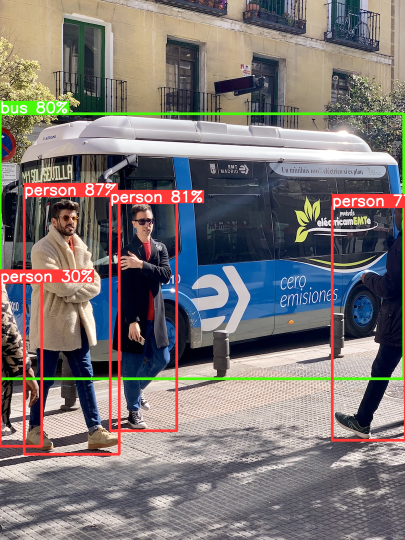

In [15]:
v = Visualizer(img_raw, model_yolov5.names)
# Prepare the prediction labels for the Visualizer
v.draw_instance_predictions(yolort_dets[0])
v.imshow(scale=0.5)